In [1]:
import autograd.numpy as np
from autograd import grad
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

In [2]:
# load the oscillator trajectory
with np.load('osctraj3.npz') as data:
    xtrue = data['arr_0']

print(xtrue.shape)
dimdata, nsteps = xtrue.shape

# need to define global constant dt
dt = 10.0/10000

# simulated observations with percentage of noise added
# y = xtrue.copy()
pctnoise = 1
myscale = (pctnoise/100.0)*np.std(xtrue,axis=1)
y = np.zeros((dimdata, nsteps))
for i in range(dimdata):
    y[i,:] = xtrue[i,:] + np.random.normal(loc=0, scale=myscale[i], size=[nsteps])

(6, 10001)


In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

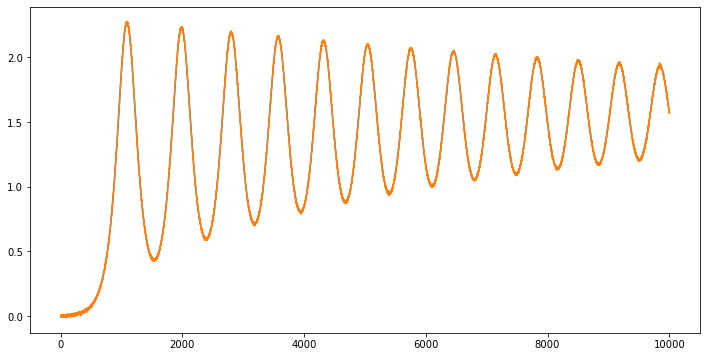

In [4]:
plt.figure(figsize=(12,6))
plt.plot(xtrue[0,:])
plt.plot(y[0,:])
plt.show()

In [5]:
# def all_products2(a):
#     x, y = np.triu_indices(len(a), 1)
#     return np.concatenate([a, a[x] * a[y]])

# following function assumes GLOBALS degrees and whichdim have been defined
def all_products_maxdeg(a, m, ndim):
    degrees = flatten([[i]*ndim for i in range(1,m+1)])
    whichdim = list(range(ndim))*m
    x, y = np.triu_indices(len(a), 1)
    x2 = []
    y2 = []
    for i in range(len(x)):
        if degrees[x[i]] + degrees[y[i]] <= m:
            if whichdim[x[i]] != whichdim[y[i]]:
                x2.append(x[i])
                y2.append(y[i])
    return np.concatenate([a, a[x2] * a[y2]])

def flatten(x):
    return [item for sublist in x for item in sublist]

def all_productsCHAR(a):
    x, y = np.triu_indices(len(a), 1)
    return [a[x[i]] + '*' + a[y[i]] for i in range(len(x))] 

# following function assumes GLOBALS degrees and whichdim have been defined
def all_products_maxdegCHAR(a, m, ndim):
    degrees = flatten([[i]*ndim for i in range(1,m+1)])
    whichdim = list(range(ndim))*m
    x, y = np.triu_indices(len(a), 1)
    x2 = []
    y2 = []
    for i in range(len(x)):
        if degrees[x[i]] + degrees[y[i]] <= m:
            if whichdim[x[i]] != whichdim[y[i]]:
                x2.append(x[i])
                y2.append(y[i])
    return [a[x2[i]] + '*' + a[y2[i]] for i in range(len(x2))] 


In [6]:
def getxi(xx, maxpow):
    ndim, npts = xx.shape
    degrees = flatten([[i]*ndim for i in range(1,maxpow+1)])
    whichdim = list(range(ndim))*maxpow
    mypow = lambda i : np.power(xx, i)
    allpow = np.reshape(np.stack(list(map(mypow, np.arange(1,(maxpow+1))))),[maxpow*ndim, npts])
    allprodm = all_products_maxdeg(allpow, maxpow, ndim)
    
    coords = ['x' + str(i) for i in range(1,ndim+1)]
    coordpowers = []
    for k in range(2,(maxpow+1)):
        coordpowers.append([j + '**' + str(k) for j in coords])

    flatcp = flatten(coordpowers)
    for j in flatcp:
        coords.append(j)
    prodlabels = all_products_maxdegCHAR(coords, maxpow, ndim)
    alllabels = coords + prodlabels
    
    return allprodm, alllabels

In [10]:
xest = y.copy()
bigxi, labs = getxi(xest[:,1:-1], 3)
print(len(bigxi))
print(labs)

63
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x1**2', 'x2**2', 'x3**2', 'x4**2', 'x5**2', 'x6**2', 'x1**3', 'x2**3', 'x3**3', 'x4**3', 'x5**3', 'x6**3', 'x1*x2', 'x1*x3', 'x1*x4', 'x1*x5', 'x1*x6', 'x1*x2**2', 'x1*x3**2', 'x1*x4**2', 'x1*x5**2', 'x1*x6**2', 'x2*x3', 'x2*x4', 'x2*x5', 'x2*x6', 'x2*x1**2', 'x2*x3**2', 'x2*x4**2', 'x2*x5**2', 'x2*x6**2', 'x3*x4', 'x3*x5', 'x3*x6', 'x3*x1**2', 'x3*x2**2', 'x3*x4**2', 'x3*x5**2', 'x3*x6**2', 'x4*x5', 'x4*x6', 'x4*x1**2', 'x4*x2**2', 'x4*x3**2', 'x4*x5**2', 'x4*x6**2', 'x5*x6', 'x5*x1**2', 'x5*x2**2', 'x5*x3**2', 'x5*x4**2', 'x5*x6**2', 'x6*x1**2', 'x6*x2**2', 'x6*x3**2', 'x6*x4**2', 'x6*x5**2']


2

In [27]:
dof = dimdata//2
gtmat = np.zeros((dimdata, len(labs)))
for i in range(dof):
    gtmat[i,i+dof] = 1
for i in range(1,1+dof):
    im1 = i-1
    ip1 = i+1
    if i==1:
        im1 += dof
    if i==dof:
        ip1 -= dof
    terms = []
    coefs = []
    terms.append('x'+str(im1))
    coefs.append(-16)
    terms.append('x'+str(i))
    coefs.append(32)
    terms.append('x'+str(ip1))
    coefs.append(-16)
    terms.append('x'+str(im1)+'**3')
    coefs.append(1)
    terms.append('x'+str(i)+'**3')
    coefs.append(-2)
    terms.append('x'+str(ip1)+'**3')
    coefs.append(1)
    print(im1)
    print(i)
    print(ip1)
    if i>1:
        terms.append('x'+str(im1)+'*'+'x'+str(i)+'**2')
        coefs.append(3)
        terms.append('x'+str(i)+'*'+'x'+str(im1)+'**2')
        coefs.append(-3)
    else:
        terms.append('x'+str(i)+'*'+'x'+str(im1)+'**2')
        coefs.append(-3)
        terms.append('x'+str(im1)+'*'+'x'+str(i)+'**2')
        coefs.append(3)
    if i<dof:
        terms.append('x'+str(i)+'*'+'x'+str(ip1)+'**2')
        coefs.append(-3)
        terms.append('x'+str(ip1)+'*'+'x'+str(i)+'**2')
        coefs.append(3)
    else:
        terms.append('x'+str(ip1)+'*'+'x'+str(i)+'**2')
        coefs.append(3)
        terms.append('x'+str(i)+'*'+'x'+str(ip1)+'**2')
        coefs.append(-3)
    indices = []
    for term in terms:
        indices.append(labs.index(term))
    
    for j in range(len(coefs)):
        gtmat[(i+dof-1), indices[j]] = coefs[j]
    
print(gtmat)
np.savez('gtmat.npz',gtmat=gtmat)

3
1
2
1
2
3
2
3
1
[[  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [ 3

In [8]:
# plt.plot((xtrue[0,2:] - xtrue[0,:-2])/(2*dt))
# plt.plot(-np.sin(tvec))
# plt.show()

In [9]:
def sparsereg(xest, maxpow=2, thresh=0.2):
    # centered difference approximation of derivative
    xdot = ((xest[:,2:] - xest[:,:-2])/(2*dt)).T
    # get rid of first and last observation to match second dimension of xdot
    bigxi, labs = getxi(xest[:,1:-1], maxpow)
    bigxi = bigxi.T

    # iterated sparse regression
    # do this by dimension
    beta = np.zeros((1 + bigxi.shape[1], xest.shape[0]))
    for curdim in range(xest.shape[0]):
        goodcols = np.array(list(range(bigxi.shape[1])))
        doneFlag = False
        while doneFlag == False:
            reg = LinearRegression().fit(bigxi[:,goodcols], xdot[:,curdim])
            newgoodcols = goodcols[np.where(np.abs(reg.coef_) >= thresh)[0]]
            if len(goodcols) == len(newgoodcols):
                if np.sum(np.abs(goodcols - newgoodcols)) == 0:
                    doneFlag = True
                    beta[0, curdim] = reg.intercept_
                    beta[1 + goodcols, curdim] = reg.coef_
            goodcols = newgoodcols
    
    bigxi = np.hstack([np.ones((bigxi.shape[0], 1)), bigxi])
    labs = ['1'] + labs
    return beta, bigxi, labs


In [10]:
# ndim, npts = xest.shape
# np2 = npts//2
# xnplus0 = xest[:, :np2]
# xnminus0 = xest[:, np2:]
# fullx = np.hstack([xnplus0, xnminus0])
# test, _ = getxi(fullx, 2)
# print(fullx.shape)
# frhs = (betahat[[0],:] + np.matmul(test.T, betahat[1:,:])).T
# np.diff(fullx, axis=1).shape
# frhs[:,:-1].shape
# maxpow=2
# lamb = 1.
# def xnminusobj(xnminusflat):
#     xnminus = np.reshape(xnminusflat.flatten(),(2,-1))
#     fullx = np.hstack([xnplus0, xnminus])
#     test, _ = getxi(fullx, maxpow)
#     frhs = (betahat[[0],:] + np.matmul(test.T, betahat[1:,:])).T
#     out = np.sum(np.square(np.diff(fullx, axis=1) - frhs[:,:-1]*dt))
#     out = out + lamb*np.sum(np.square( xnminus - xnminus0 ))
#     return out

# gradxnminusobj = grad(xnminusobj)

# res = minimize(xnminusobj, xnminus0.flatten(), method='L-BFGS-B', 
#                jac=gradxnminusobj, options={'disp': True, 'maxcor': 100})

# xnminus = np.reshape(res['x'].flatten(),(2,-1))

# np.linalg.norm(xnminus - xnminus0)

In [11]:
# now fix theta
# with theta fixed, fix x^+ and estimate x^-
# with theta and x^- fixed, estimate x^+
def filterstep(xn, betahat, maxpow=2, lamb=1):
    # split xn into xn+ and xn-
    ndim, npts = xn.shape
    np2 = npts//2
    xnplus0 = xn[:, :np2]
    xnminus0 = xn[:, np2:]
    
    # define first objective function
    def xnminusobj(xnminusflat):
        xnminus = np.reshape(xnminusflat.flatten(),(ndim,-1))
        fullx = np.hstack([xnplus0, xnminus])
        test, _ = getxi(fullx, maxpow)
        frhs = (betahat[[0],:] + np.matmul(test.T, betahat[1:,:])).T
        out = np.sum(np.square((np.diff(fullx, axis=1) - frhs[:,:-1]*dt)))
        out = out + lamb*np.sum(np.square( xnminus - xnminus0 ))
        return out
    
    # autograd
    gradxnminusobj = grad(xnminusobj)
    
    # use BFGS to minimize
    res = minimize(xnminusobj, xnminus0.flatten(), method='L-BFGS-B', 
               jac=gradxnminusobj, options={'disp': True, 'maxcor': 100})
    
    xnminus1 = np.reshape(res['x'].flatten(),(ndim,-1))

    def xnplusobj(xnplusflat):
        xnplus = np.reshape(xnplusflat.flatten(),(ndim,-1))
        fullx = np.hstack([xnplus, xnminus1])
        test, _ = getxi(fullx, maxpow)
        frhs = (betahat[[0],:] + np.matmul(test.T, betahat[1:,:])).T
        out = np.sum(np.square((np.diff(fullx, axis=1) - frhs[:,:-1]*dt)))
        out = out + lamb*np.sum(np.square( xnplus - xnplus0 ))
        return out
    
    # autograd
    gradxnplusobj = grad(xnplusobj)
    
    # use BFGS to minimize
    res = minimize(xnplusobj, xnplus0.flatten(), method='L-BFGS-B', 
               jac=gradxnplusobj, options={'disp': True, 'maxcor': 100})
    
    xnplus1 = np.reshape(res['x'].flatten(),(ndim,-1))
    
    newx = np.hstack([xnplus1, xnminus1])
    return newx


In [12]:
betahat, _, labs = sparsereg(y, maxpow=3, thresh=0.1)
# xest1 = filterstep( xn=y, betahat=betahat, maxpow=3, lamb=10 )
# plt.plot(y[0,:], y[1,:])
# plt.plot(xest1[0,:], xest1[1,:], color='red')
# plt.show()

In [13]:
print(betahat[40,:])
print(labs)

[  376.82370427 -1854.3482336    608.19186182 -4776.01181983
   -12.46286624 -1434.80478575]
['1', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x1**2', 'x2**2', 'x3**2', 'x4**2', 'x5**2', 'x6**2', 'x1**3', 'x2**3', 'x3**3', 'x4**3', 'x5**3', 'x6**3', 'x1*x2', 'x1*x3', 'x1*x4', 'x1*x5', 'x1*x6', 'x1*x2**2', 'x1*x3**2', 'x1*x4**2', 'x1*x5**2', 'x1*x6**2', 'x2*x3', 'x2*x4', 'x2*x5', 'x2*x6', 'x2*x1**2', 'x2*x3**2', 'x2*x4**2', 'x2*x5**2', 'x2*x6**2', 'x3*x4', 'x3*x5', 'x3*x6', 'x3*x1**2', 'x3*x2**2', 'x3*x4**2', 'x3*x5**2', 'x3*x6**2', 'x4*x5', 'x4*x6', 'x4*x1**2', 'x4*x2**2', 'x4*x3**2', 'x4*x5**2', 'x4*x6**2', 'x5*x6', 'x5*x1**2', 'x5*x2**2', 'x5*x3**2', 'x5*x4**2', 'x5*x6**2', 'x6*x1**2', 'x6*x2**2', 'x6*x3**2', 'x6*x4**2', 'x6*x5**2']


In [14]:
# idea
# create columns

# fit linear model
# threshold
# repeat
# then fix theta, define function that returns vector field
# then fit x^+ and x^-

In [43]:
# set up BCD prox
# idea: apply alternating minimization and sparse linear regression
# monitor monotonic convergence!

# first estimate \theta
# then estimate x^-
# then estimate x^+

# model for \theta:

xest = y.copy()

niter = 100
for i in range(niter):
    betahat, _, labs = sparsereg(xest, maxpow=3, thresh=0.15)
    # print(betahat)
    xest1 = filterstep( xn=xest, betahat=betahat, maxpow=3, lamb=0.1 )
    print(np.linalg.norm(xest1 - xest))
    xest = xest1
    

KeyboardInterrupt: 

In [35]:
# vectorized RHS vector field
# accepts n x k array as input, where n = dimension of vector field
# returns n x k array as output
# here k is arbitrary
def estimatedrhs(t, x):
    test, _ = getxi(x, maxpow=3)
    frhs = (betahat[[0],:] + np.matmul(test.T, betahat[1:,:])).T
    return(frhs)

In [36]:
from scipy.integrate import solve_ivp

In [37]:
ic = xest[:,0]
ft = 10.0
numpts = 10000
t_eval = np.arange(numpts+1)*(ft/numpts)
sol = solve_ivp(fun=estimatedrhs, t_span=[0, ft], y0=ic, t_eval=t_eval, rtol=1e-8, atol=1e-8, vectorized=True)

In [38]:
print(sol.y.shape)

(6, 100)


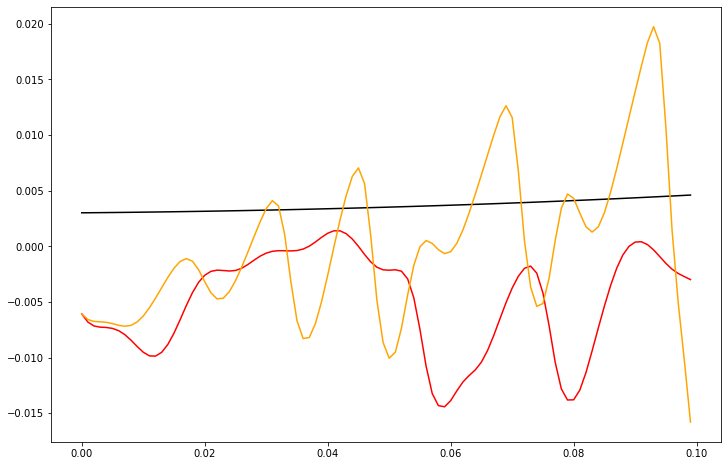

In [42]:
plt.figure(figsize=(12,8))
plt.plot(t_eval[:sol.y.shape[1]],xest[0,:sol.y.shape[1]],color='red')
plt.plot(t_eval[:sol.y.shape[1]],xtrue[0,:sol.y.shape[1]],color='black')
plt.plot(t_eval[:sol.y.shape[1]],sol.y[0,:],color='orange')
plt.show()

In [34]:
betahat[6,:]

array([  600.65442127,  -365.23100796,  -497.37643288,  2735.0533969 ,
       -4132.9819464 ,  1373.34502087])

In [33]:
niter = 10
for i in range(niter):
    betahat, _, labs = sparsereg(xest, maxpow=3, thresh=0.1)
    # print(betahat)
    xest1 = filterstep( xn=xest, betahat=betahat, maxpow=3, lamb=0.1 )
    print(np.linalg.norm(xest1 - xest))
    xest = xest1

0.12301331292919782
0.09122827649885326
0.07700096955107524
0.06873600983068678
0.0632332270723439
0.05935051702487234
0.05627585455806756
0.05379861888968357
0.05188006236758066
0.05046264044479574
